# Classical Approaches

We will study different approaches for binary digit classification (two classes). We first explore a naive classification approach based on counting the number of "white" pixels. We then use a logistic regression where every pixel is a feature. Finally, we test a logistic regression using a small set of derived imaging features.

**Objective:** Observe differences between three different classification approaches

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Data

In [6]:
data_dir = './data'
train_set = MNIST(data_dir, train=True, download=True)
test_set = MNIST(data_dir, train=False, download=True)
print(train_set.data.shape)
print(test_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
def plot_digits(data, n_samples_row=10, colormap = matplotlib.cm.gray, clim=None):
    images = [image.reshape(28,28) for image in data]
    n_rows = (len(images) - 1) // n_samples_row + 1
    # append empty images if the last row is not complete
    empty_images = n_rows * n_samples_row - len(data)
    images.append(np.zeros((28, 28 * empty_images)))
    # draw row by row
    images_row = []
    for current_row in range(n_rows):
        tmp_row_images = images[current_row * n_samples_row : (current_row + 1) * n_samples_row]
        images_row.append(np.concatenate(tmp_row_images, axis=1))
    # draw all in one image
    image = np.concatenate(images_row, axis=0)
    plt.figure(figsize=(n_samples_row,n_rows))
    plt.imshow(image, cmap = colormap, clim=clim)
    plt.colorbar()
    plt.axis("off")

Let's plot some random examples from the MNIST dataset

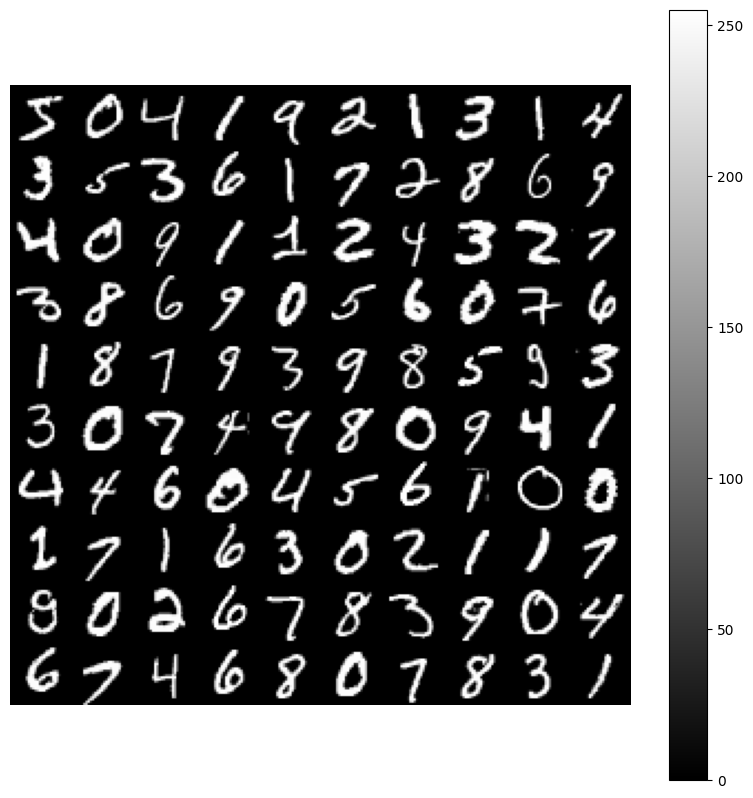

In [8]:
plot_digits(train_set.data[:100])
plt.show()

## Experiments

**Task:** Change the selected digits to [0,8] and other combinations, and observe the effect on the classification approaches.

In [9]:
selected_digits = [1,8]

selected_indexes = np.isin(train_set.targets, selected_digits)
train_data = np.array(train_set.data[selected_indexes]).astype(np.float32) / 255.0
train_labels = np.array(train_set.targets[selected_indexes] == selected_digits[1])

selected_indexes = np.isin(test_set.targets, selected_digits)
test_data = np.array(test_set.data[selected_indexes]).astype(np.float32) / 255.0
test_labels = np.array(test_set.targets[selected_indexes] == selected_digits[1])

nsamples, nx, ny = train_data.shape
train_data = np.reshape(train_data,(nsamples,nx*ny))

nsamples, nx, ny = test_data.shape
test_data = np.reshape(test_data,(nsamples,nx*ny)).astype(np.float32)

Let's plot some random examples from the training set with selected digit classes

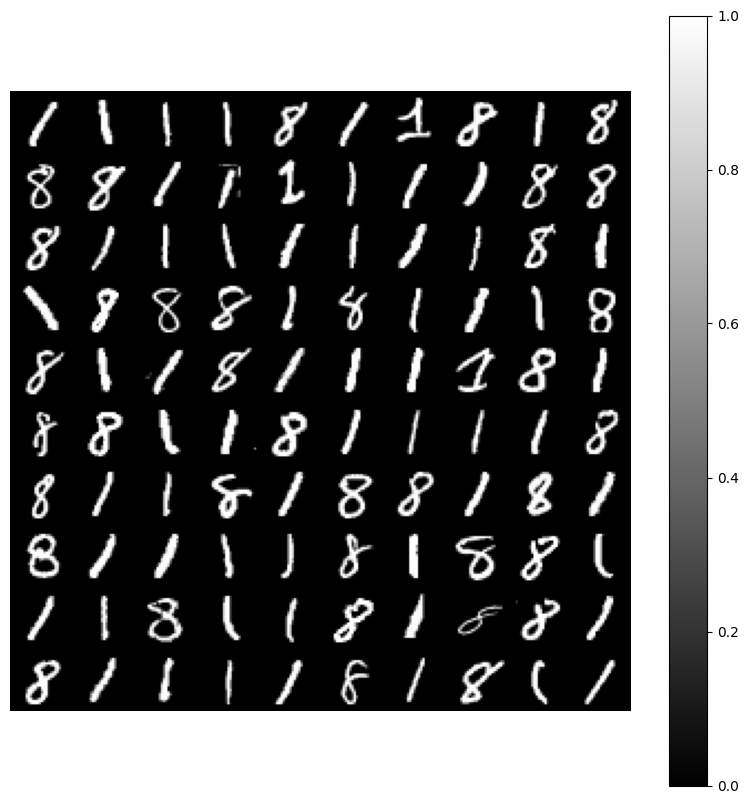

In [10]:
plot_digits(train_data[:100])
plt.show()

### Approach 1: Classification via naive thresholding on hand-crafted feature

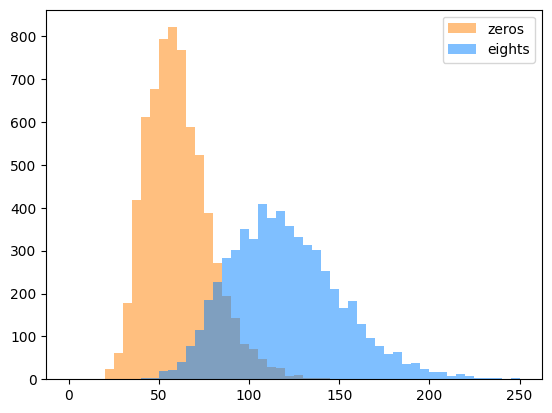

In [11]:
sum_digit_0 = np.sum(train_data[train_labels==0]>0.5, axis=1)
sum_digit_1 = np.sum(train_data[train_labels==1]>0.5, axis=1)

plt.hist(sum_digit_0, bins=50, range=(0.0, 250.0), fc=[1,0.5,0,0.5], alpha=0.5)
plt.hist(sum_digit_1, bins=50, range=(0.0, 250.0), fc=[0,0.5,1,0.5], alpha=0.5)
plt.legend(['zeros','eights'])
plt.show()

Based on the histogram, let's choose a sensible threshold that separates the two classes

In [12]:
threshold = 85
sum_digit_pixels = np.sum(train_data>0.5, axis=1)
train_predictions = sum_digit_pixels >= threshold

sum_digit_pixels = np.sum(test_data>0.5, axis=1)
test_predictions = sum_digit_pixels >= threshold

Calculate and report the classification accuracy

In [13]:
train_acc = 100.0 * (train_predictions == train_labels).mean()
print('Train accuracy = {:.2f}%'.format(train_acc))

test_acc = 100.0 * (test_predictions == test_labels).mean()
print('Test accuracy = {:.2f}%'.format(test_acc))

Train accuracy = 89.56%
Test accuracy = 90.47%


### Approach 2: Logistic regression using all pixels as features

Let's use a logistic regression model from the scikit-learn library

In [14]:
model = linear_model.LogisticRegression(C=.0001, solver='liblinear')
model.fit(train_data, train_labels)

LogisticRegression(C=0.0001, solver='liblinear')

Calculate and report the classification accuracy

In [15]:
train_preds = model.predict(train_data)
logistic_train_acc = 100.0 * (train_preds == train_labels).mean()
print('Train accuracy = {:.2f}%'.format(logistic_train_acc))

test_preds = model.predict(test_data)
logistic_test_acc = 100.0 * (test_preds == test_labels).mean()
print('Test accuracy = {:.2f}%'.format(logistic_test_acc))

Train accuracy = 95.89%
Test accuracy = 97.01%


Let's inspect the learned pattern

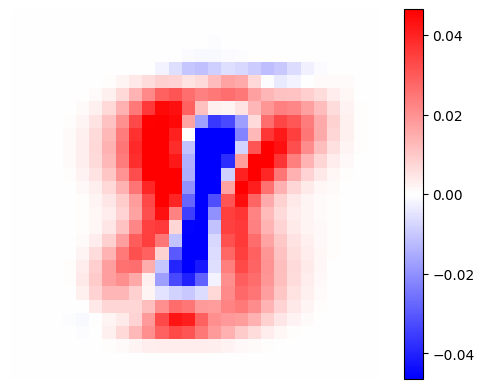

In [16]:
vmax = np.max(np.abs(model.coef_)) / 2
plt.imshow(model.coef_.reshape(28,28), cmap=matplotlib.cm.bwr, clim=(-vmax,vmax))
plt.colorbar()
plt.axis('off')
plt.show()

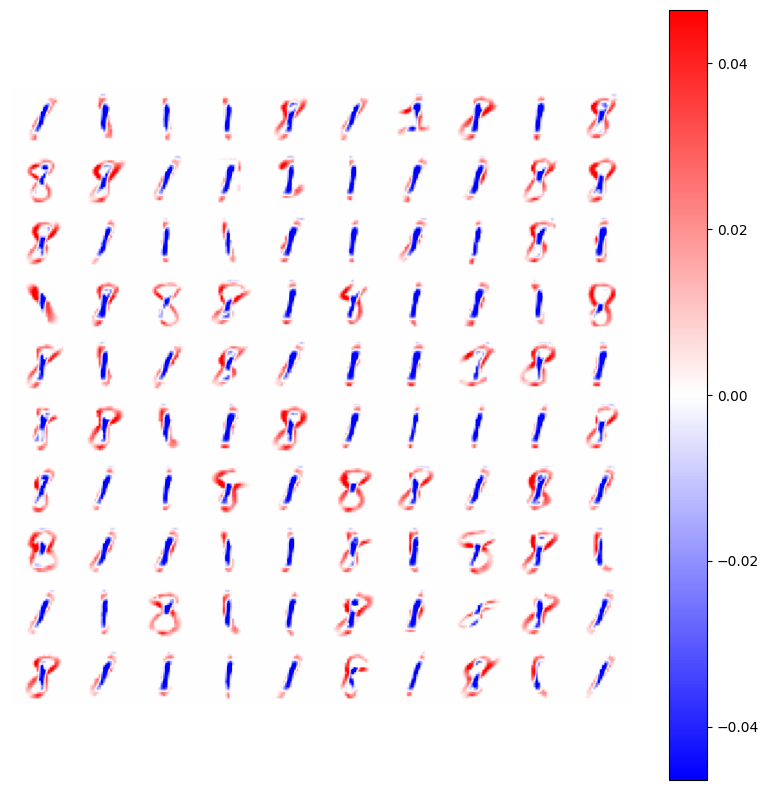

In [17]:
pattern = np.tile(model.coef_, (100, 1))
plot_digits(np.multiply(train_data[:100],pattern), colormap=matplotlib.cm.bwr, clim=(-vmax,vmax))
plt.show()

### Approach 3: Logistic regression using image-derived features

We load the Morpho-MNIST dataset which contains pre-computed, image-derived features for MNIST digits

In [18]:
train_set2 = pd.read_csv(data_dir + '/MNIST/train-morpho.csv')
train_set2['class label'] = train_set.targets
test_set2 = pd.read_csv(data_dir + '/MNIST/t10k-morpho.csv')
test_set2['class label'] = test_set.targets

train_set2.head() # show the first five data entries of the training set

,index,area,length,thickness,slant,width,height,class label
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054,5
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053,0
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880,4
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599,1
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523,9


Let's inspect the feature separation across all digit classes for a random sample with 1,000 digits and two of the features. Feel free to try it out with other feature combinations.

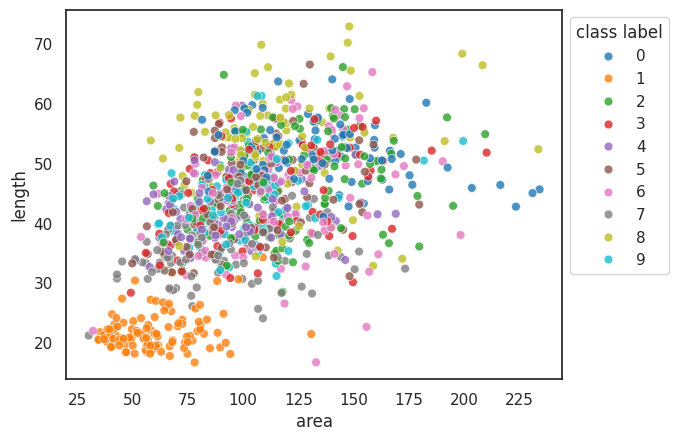

In [19]:
sns.set_theme(style="white")
ax = sns.scatterplot(data=test_set2.sample(n=1000), x='area', y='length', hue='class label', alpha=0.8, marker='o', s=40, palette='tab10')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [20]:
# Reformat the data
train_data2_all = np.transpose(np.array([train_set2['area'].values,train_set2['length'].values,train_set2['thickness'].values,train_set2['slant'].values,train_set2['width'].values,train_set2['height'].values]))
test_data2_all = np.transpose(np.array([test_set2['area'].values,test_set2['length'].values,test_set2['thickness'].values,test_set2['slant'].values,test_set2['width'].values,test_set2['height'].values]))

In [21]:
selected_indexes = np.isin(train_set.targets, selected_digits)
train_data2 = np.array(train_data2_all[selected_indexes]).astype(np.float32)
train_labels2 = np.array(train_set.targets[selected_indexes] == selected_digits[1])

selected_indexes = np.isin(test_set.targets, selected_digits)
test_data2 = np.array(test_data2_all[selected_indexes]).astype(np.float32)
test_labels2 = np.array(test_set.targets[selected_indexes] == selected_digits[1])

We normalise the features using feature scaling before feeding into the logistic regression

In [22]:
pipe = make_pipeline(StandardScaler(), linear_model.LogisticRegression(C=.0001, solver='liblinear'))
pipe.fit(train_data2, train_labels2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, solver='liblinear'))])

Calculate and report the classification accuracy

In [23]:
train_preds2 = pipe.predict(train_data2)
logistic_train_acc2 = 100.0 * (train_preds2 == train_labels2).mean()
print('Train accuracy = {:.2f}%'.format(logistic_train_acc2))

test_preds2 = pipe.predict(test_data2)
logistic_test_acc2 = 100.0 * (test_preds2 == test_labels2).mean()
print('Test accuracy = {:.2f}%'.format(logistic_test_acc2))

Train accuracy = 98.28%
Test accuracy = 99.00%
